# Imports

In [1]:
import pandas as pd
import sys 
import os
import math
import numpy as np 
import joblib
import seaborn as sns

from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML
pd.set_option('display.float_format', lambda x: '%.4f' % x)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor




sys.path.insert(0, '../src/')
from utils.utils import load_config_file
from data.data_load import DataLoad
from data.data_preprocess import DataPreprocess
from data.data_transformation import DataTransformation


import warnings

# Ignorar todos os FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Helper Functions

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def regression_metrics(y_true, y_pred):
    """
    Calcula várias métricas de regressão e retorna um DataFrame.

    Parâmetros:
    - y_true: Valores reais.
    - y_pred: Valores preditos.

    Retorna:
    - DataFrame contendo métricas de regressão.
    """

    absolute_errors = np.abs(y_true - y_pred)
    percentage_errors = absolute_errors / np.maximum(np.abs(y_true), 1e-8)

    metrics_dict = {
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(percentage_errors) * 100
        # Adicione mais métricas conforme necessário
    }

    metrics_df = pd.DataFrame(list(metrics_dict.items()), columns=['Métrica', 'Valor'])
    return metrics_df


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
import pandas as pd

class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        self.le = LabelEncoder()
        self.default_label = 'desconhecido'
        self.categories_ = None

    def fit(self, X, y=None):
        all_categories = set(X[self.column])
        all_categories.add(self.default_label)  # Adicione 'desconhecido' às categorias conhecidas
        self.le.fit(list(all_categories))
        self.categories_ = all_categories
        return self

    def transform(self, X):
        X_encoded = X.copy()
        # Usar um valor padrão para categorias desconhecidas
        X_encoded[self.column] = X_encoded[self.column].apply(lambda x: x if x in self.categories_ else self.default_label)
        X_encoded[self.column] = self.le.transform(X_encoded[self.column])
        return X_encoded
    

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

# jupyter_settings()

# Data Load

In [3]:
dl = DataLoad()
df = dl.load_data('dados_train')

c:\Users\thale\Documents\Projetos_DS\projeto_aluno_mlflow\delivery_fast\notebooks\../src\data
2023-12-27 15:45:48 [info     ] Iniciando o carregamento
c:\Users\thale\Documents\Projetos_DS\projeto_aluno_mlflow\delivery_fast\src\data
c:\Users\thale\Documents\Projetos_DS\projeto_aluno_mlflow\delivery_fast\data\raw\dados.csv


# 1.0 Descrição dos Dados

In [4]:
df1 = df.copy()

## 1.1 Dimensão dos Dados

In [5]:
df1.shape

(197428, 16)

## 1.2 Tipo dos Dados

In [6]:
df1.dtypes

market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
store_primary_category                           object
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
dtype: object

## 1.3 Check Na

In [7]:
df1.isna().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

# 2.0 Fill Na

In [8]:
df2 = df1.copy()

In [9]:
df2 = df2.dropna()

In [10]:
# # total_onshift_dashers
# df2['total_onshift_dashers'] = df2['total_onshift_dashers'].apply(lambda x: 0 if math.isnan(x) else x)

# # total_busy_dashers
# df2['total_busy_dashers'] = df2['total_busy_dashers'].apply(lambda x: 0 if math.isnan(x) else x)

# # total_outstanding_orders
# df2['total_outstanding_orders'] = df2['total_outstanding_orders'].apply(lambda x: 0 if math.isnan(x) else x)

In [11]:
# df2[['store_id','store_primary_category']].groupby('store_id').count().reset_index().sort_values('store_primary_category', ascending=False)

In [12]:
# df2.loc[df2['store_id'] == 6865]['store_primary_category'].value_counts()

# 3.0 Change Data Type

In [13]:
df3 = df2.copy()

In [14]:
df3.dtypes

market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
store_primary_category                           object
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
dtype: object

In [15]:
df3['created_at'] = pd.to_datetime(df3['created_at'])

df3['actual_delivery_time'] = pd.to_datetime(df3['actual_delivery_time'])

In [16]:
df3.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0000,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0000,4,3441,4,557,1239,33.0000,14.0000,21.0000,446,861.0000
1,2.0000,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0000,1,1900,1,1400,1400,1.0000,2.0000,2.0000,446,690.0000
8,2.0000,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0000,4,4771,3,820,1604,8.0000,6.0000,18.0000,446,289.0000
14,1.0000,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0000,1,1525,1,1525,1525,5.0000,6.0000,8.0000,446,795.0000
15,1.0000,2015-01-27 02:12:36,2015-01-27 03:02:24,2841,italian,1.0000,2,3620,2,1425,2195,5.0000,5.0000,7.0000,446,205.0000


# 4.0 Feature Engineering

In [17]:
df4 = df3.copy()

In [18]:
# df4.loc[df4['total_onshift_dashers'] < df4['total_busy_dashers']]

# dia do mes do pedido
df4['dia_mes'] = df4['created_at'].dt.day

# dia do ano do pedido
df4['dia_ano'] = df4['created_at'].dt.day_of_year

# mes do pedido
df4['mes'] = df4['created_at'].dt.month

# ano do pedido
df4['ano'] = df4['created_at'].dt.year

# bimestre
df4['bimestre'] = df4['created_at'].dt.month // 2 + 1

# trimestre
df4['trimestre'] = df4['created_at'].dt.quarter

# semestre
df4['semestre'] = df4['created_at'].dt.quarter.apply(lambda x: (x - 1) // 2 + 1)

# manha/tarde/noite/madrugada
df4['periodo'] = pd.cut(df4['created_at'].dt.hour,
                        bins=[0, 6, 12, 18, 24],
                        labels=['madrugada', 'manhã', 'tarde', 'noite'],
                        include_lowest=True)

# Quantidade de pedidos feitos até o momento do pedido atual no mesmo market_id
df_test = df4.sort_values(by=['market_id', 'created_at'])

# Criando a coluna 'quantidade_pedidos_ate_o_momento'
df4['quantidade_pedidos_ate_o_momento'] = df_test.groupby(['market_id', df_test['created_at'].dt.date]).cumcount() + 1

# Tempo médio de entrega dos pedidos feitos até o momento do pedido atual


In [19]:
df4['target'] = (df4['actual_delivery_time'] - df4['created_at']).dt.total_seconds()

# 5.0 EDA

In [20]:
df5 = df4.copy()

## 5.1 Análise Univariada

In [21]:
num_attributes = df5.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df5.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [22]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,market_id,1.0000,6.0000,5.0000,2.7437,2.0000,1.3310,0.2256,-1.1985
1,store_id,1.0000,6987.0000,6986.0000,3556.2996,3620.0000,2055.9532,-0.0232,-1.2447
2,order_protocol,1.0000,7.0000,6.0000,2.9118,3.0000,1.5131,0.1094,-1.3290
3,total_items,1.0000,411.0000,410.0000,3.2050,3.0000,2.6740,23.2860,3102.9680
4,subtotal,0.0000,26800.0000,26800.0000,2697.1111,2224.0000,1828.5497,1.9184,5.5952
5,num_distinct_items,1.0000,20.0000,19.0000,2.6751,2.0000,1.6257,1.5743,4.1767
6,min_item_price,-86.0000,14700.0000,14786.0000,684.9654,595.0000,519.8814,2.3388,14.7339
7,max_item_price,0.0000,14700.0000,14700.0000,1160.1586,1095.0000,560.8270,2.2043,12.9622
8,total_onshift_dashers,-4.0000,171.0000,175.0000,44.9187,37.0000,34.5446,0.8569,-0.0435
9,total_busy_dashers,-5.0000,154.0000,159.0000,41.8614,35.0000,32.1684,0.7786,-0.1980


### 5.1.2 Variável Resposta

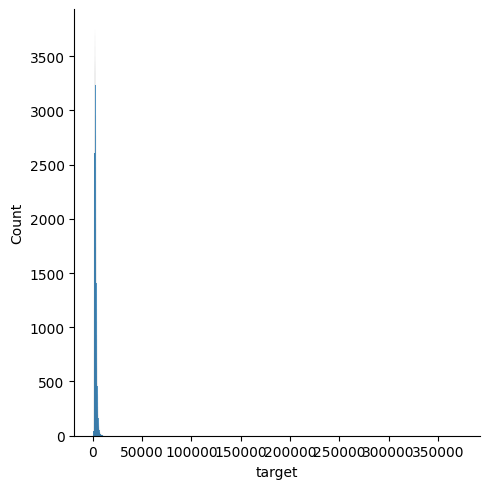

In [23]:
sns.displot( df5['target'], kde=False  )

## 5.2 Análise Bivariada

In [24]:
# plt.figure( figsize=(25, 12) )
# sns.pairplot( num_attributes.drop(columns = ['market_id','store_id', 'order_protocol']))

#### Pedidos com mais itens demoram mais??

<Axes: xlabel='total_items', ylabel='target'>

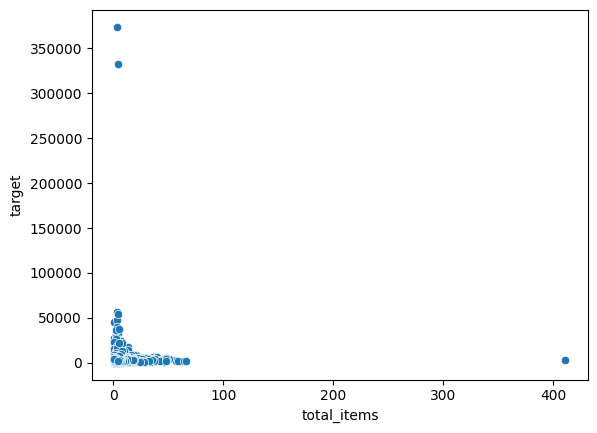

In [25]:
sns.scatterplot(x='total_items', y='target', data=num_attributes)

#### Pedidos mais caros demoram mais?

<Axes: xlabel='subtotal', ylabel='target'>

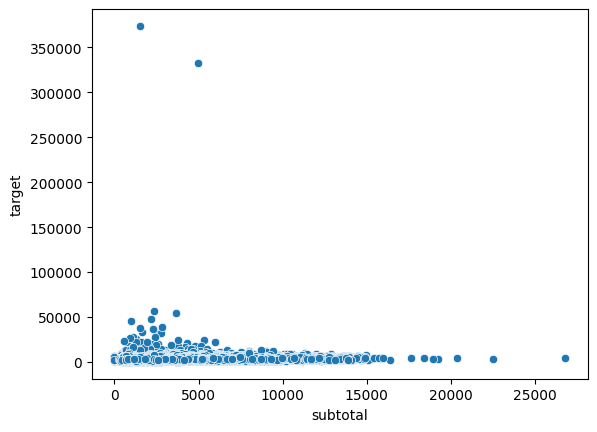

In [26]:
sns.scatterplot(x='subtotal', y='target', data=num_attributes)

#### A quantidade de Itens Distintos no pedido interfere no tempo de entrega?

<Axes: xlabel='num_distinct_items', ylabel='target'>

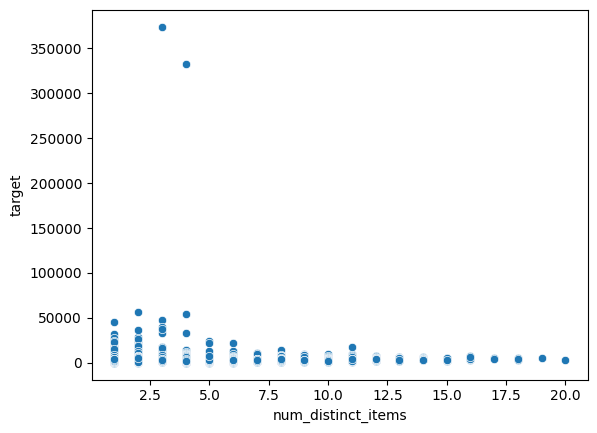

In [27]:
sns.scatterplot(x='num_distinct_items', y='target', data=num_attributes)

<Axes: xlabel='quantidade_pedidos_ate_o_momento', ylabel='target'>

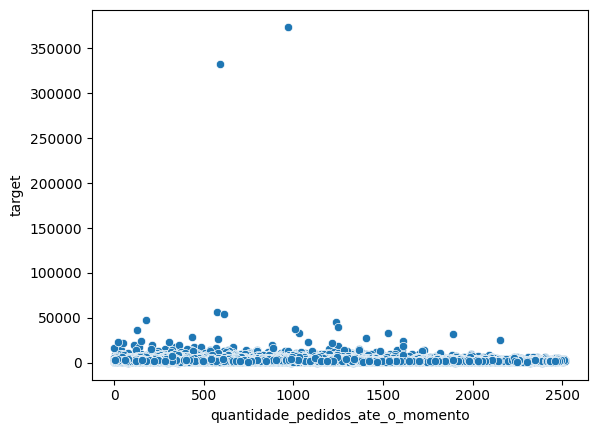

In [28]:
sns.scatterplot(x='quantidade_pedidos_ate_o_momento', y='target', data=num_attributes)

<Axes: xlabel='order_protocol', ylabel='target'>

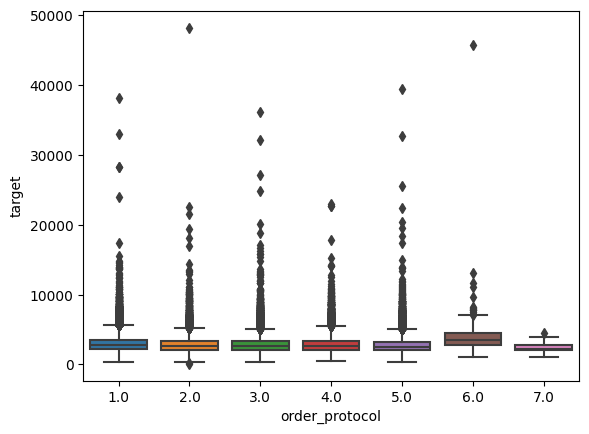

In [29]:
sns.boxplot(x='order_protocol', y='target', data=num_attributes.loc[num_attributes['target'] < 50000])

<Axes: xlabel='market_id', ylabel='target'>

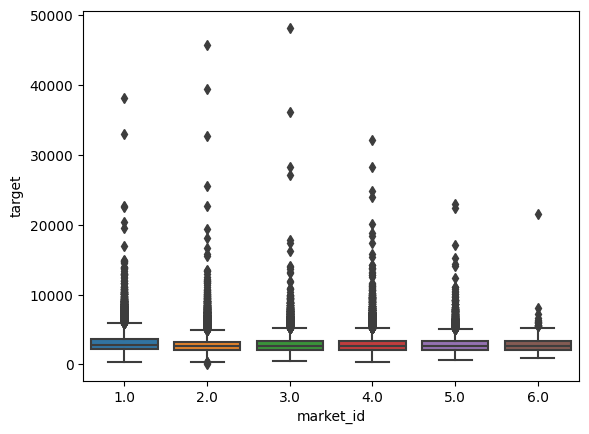

In [30]:
sns.boxplot(x='market_id', y='target', data=num_attributes.loc[num_attributes['target'] < 50000])

# 6.0 Limpeza de Dados

In [31]:
df6 = df5.copy()

In [32]:
df6 = df6.loc[df6['min_item_price'] > 0]

df6 = df6.loc[df6['total_onshift_dashers'] >= 0]

df6 = df6.loc[df6['total_busy_dashers'] >= 0]

df6 = df6.loc[df6['total_outstanding_orders'] >= 0]

df6 = df6.loc[df6['target'] < 20000]

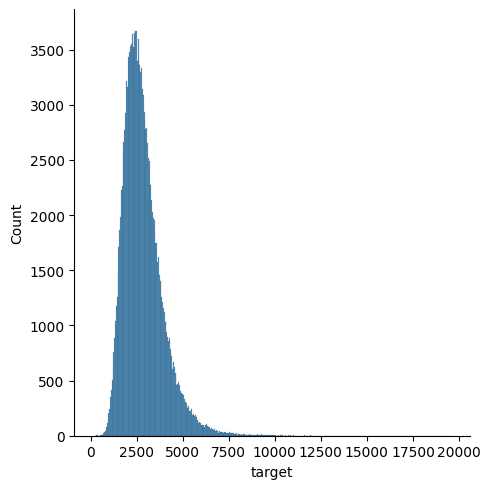

In [33]:
sns.displot( df6['target'], kde=False  )

# 7.0 Data Preparation

In [39]:
df7 = df6.copy()
df7 = df7.drop(columns=['created_at', 'actual_delivery_time'])
#df7 = df7[load_config_file().get('columns_to_use')]

In [40]:
dt = DataTransformation(df7)

In [41]:
X_train, X_valid, y_train, y_valid = dt.train_test_split()

# 6.0 Data Preprocess

## 6.1 Encoding

In [103]:
# le = LabelEncoder()

# all_categories = set(X_train['store_primary_category']).union(set(X_valid['store_primary_category']))
# le.fit(list(all_categories))

# # Dados de Treino
# X_train['store_primary_category'] = le.transform(X_train['store_primary_category'])



In [104]:
# default_label = 'desconhecido'
# X_valid['store_primary_category'] = X_valid['store_primary_category'].replace(to_replace={cat: default_label for cat in all_categories.difference(X_valid['store_primary_category'])})

# # Aplicar o LabelEncoder para transformar as categorias
# X_valid['store_primary_category'] = le.transform(X_valid['store_primary_category'])

In [105]:
# # Criar pipeline
# pipeline = Pipeline([
#     ('label_encoder', CustomLabelEncoder(column='store_primary_category')),
# ])

In [51]:
# Criar pipeline
pipeline = Pipeline([
    ('label_encoder', CustomLabelEncoder(column='store_primary_category')),
    ('label_encoder2', CustomLabelEncoder(column='periodo')),
    ('scaler', MinMaxScaler())
])

# 7.0 Machine Learning

In [54]:
import mlflow
from mlflow.tracking import MlflowClient

mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('predict_delivery_time')

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1703597813329, experiment_id='1', last_update_time=1703597813329, lifecycle_stage='active', name='predict_delivery_time', tags={}>

In [55]:
models = [LinearRegression(), Ridge(), Lasso(), KNeighborsRegressor(), DecisionTreeRegressor(), GradientBoostingRegressor()]


with mlflow.start_run(run_name='Ciclo2'):

    preprocessador = DataPreprocess(pipeline)
    preprocessador.train(X_train)

    X_train_processed = pd.DataFrame(preprocessador.transform(X_train))
    X_valid_processed = pd.DataFrame(preprocessador.transform(X_valid))

    X_train_processed.columns = X_train.columns
    X_valid_processed.columns = X_valid.columns

    joblib.dump(preprocessador, '../models/preprocess.joblib')

    # logar um artefato (preprocessador)
    mlflow.log_artifact('../models/preprocess.joblib')

    # logar os parametros do preprocessador
    mlflow.log_params(params={'encoder': pipeline['label_encoder'],
                              'encoder2': pipeline['label_encoder2'],
                            'scaler': pipeline['scaler']})

    for model in models:
        model_name = model.__class__.__name__
        print(model_name)
        with mlflow.start_run(nested=True, run_name = model_name):
            mlflow.set_tag('model_name', model_name)

            mlflow.log_param('model_name', model_name)
            md = model

            # model train
            md.fit(X_train_processed, y_train)

            # model predict
            y_pred = md.predict(X_valid_processed)

            params = md.get_params()

            # log nos parametros do modelo
            for i in params:
                mlflow.log_param(i, params[i])
            
            # Calculando as métricas de performance 
            df_result_lr = regression_metrics(y_valid, y_pred)

            # log nas métricas que vem de df_result_lr
            for index, row in df_result_lr.iterrows():
                mlflow.log_metric(row['Métrica'], row['Valor'])
            
            mlflow.sklearn.log_model(md, model_name)

2023-12-27 15:59:27 [info     ] Iniciando o processamento


2023-12-27 15:59:28 [info     ] Iniciando a Transformação
2023-12-27 15:59:28 [info     ] Iniciando a Transformação
LinearRegression
Ridge


c:\Users\thale\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\thale\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Lasso


c:\Users\thale\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\thale\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


KNeighborsRegressor


c:\Users\thale\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\thale\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


DecisionTreeRegressor


c:\Users\thale\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\thale\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


GradientBoostingRegressor


c:\Users\thale\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\thale\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
